<html>
  <h1  align="center";> Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
  </h1>
<hr>
  <h3 align="center";>
  Edición 2022
  </h3>
<hr>
  <h1 align="center";>
  Trabajo Práctico Entregable
  </h1>
  <h2 align="center";>
    Laboratorio 2
  </h2>
</html>


## Profesora del Práctico:
- Fonseca, Rocio

## Integrantes [ Grupo 5 ]:
- Argüello, Leandro Ismael
- Corral, Diego
- Racciatti. Florencia 
- Rinaudo, Eleana
- Romero, Ernest

<html>
<hr>
  <h1  align="center";>
    Introducción al Aprendizaje Automático
  </h1>
<hr>
</html>

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de **clasificación**.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: **selección de un modelo**, **ajuste de hiperparámetros** y **evaluación**.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. 

Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

# Importamos las líbrerías necesarias


In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from numpy.random import default_rng, uniform

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV,
    ParameterGrid,
    GridSearchCV,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler


## Carga de datos 

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [4]:
df = pd.read_csv("./data/loan_data.csv", comment="#")

## Preprocesamiento de Datos 

Después de cargar los datos, es una buena práctica ver si faltan valores en los datos. 

Contamos el número de valores faltantes para cada característica usando `isnull()`

In [5]:
df.isnull().sum()


TARGET     0
LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

Observamos que no hay valores faltantes en este conjunto de datos.

## Curación de datos

Primero, hacemos un análisis de correlaciones entre las variables para conocer mejor nuestros datos.


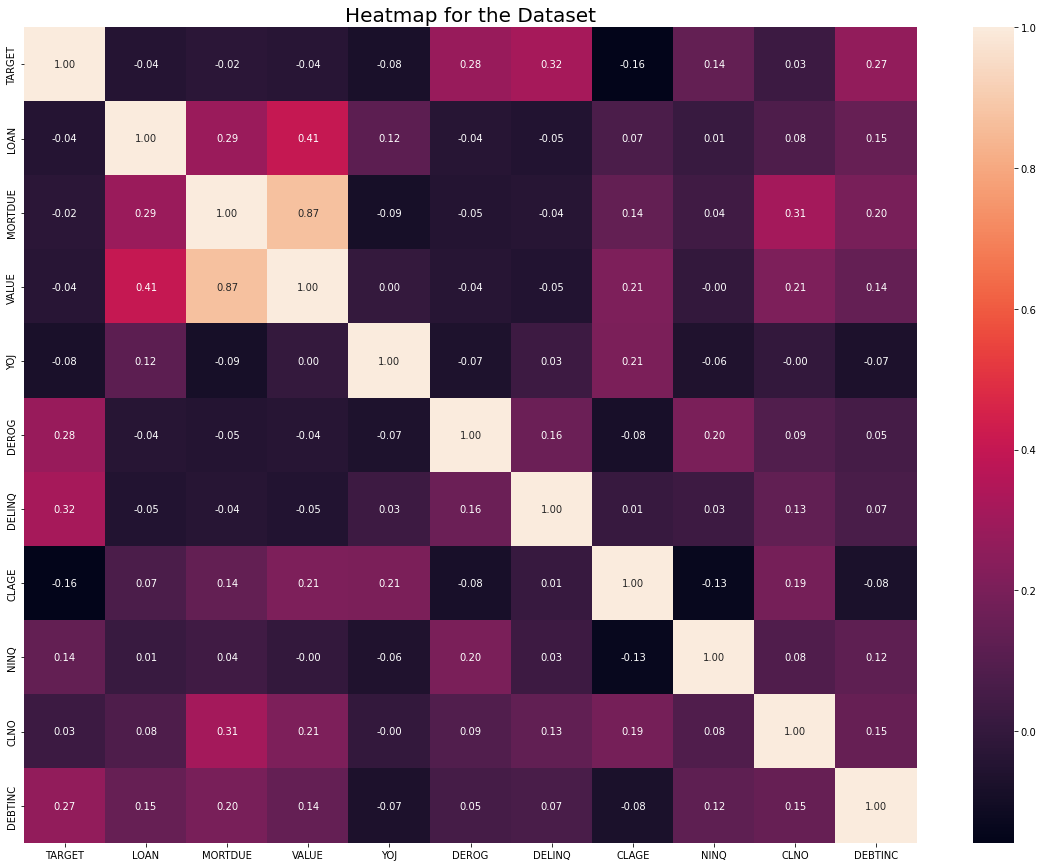

In [6]:
plt.rcParams["figure.figsize"] = (20, 15)
sns.color_palette("Set2")
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Heatmap for the Dataset", fontsize=20)
plt.show()


>**Observación:**
>
>Al tener muy pocas variables no creemos que sea beneficioso para el análisis deshacernos de alguna de ellas. Además, observamos que muy pocas variables impactan significamente a la variable `TARGET`, en un porcentaje entre el 14% y el 32%.



Observamos las columnas a tratar

In [7]:
columns_list = df.columns


### Mostramos la distribución de los valores de las variables

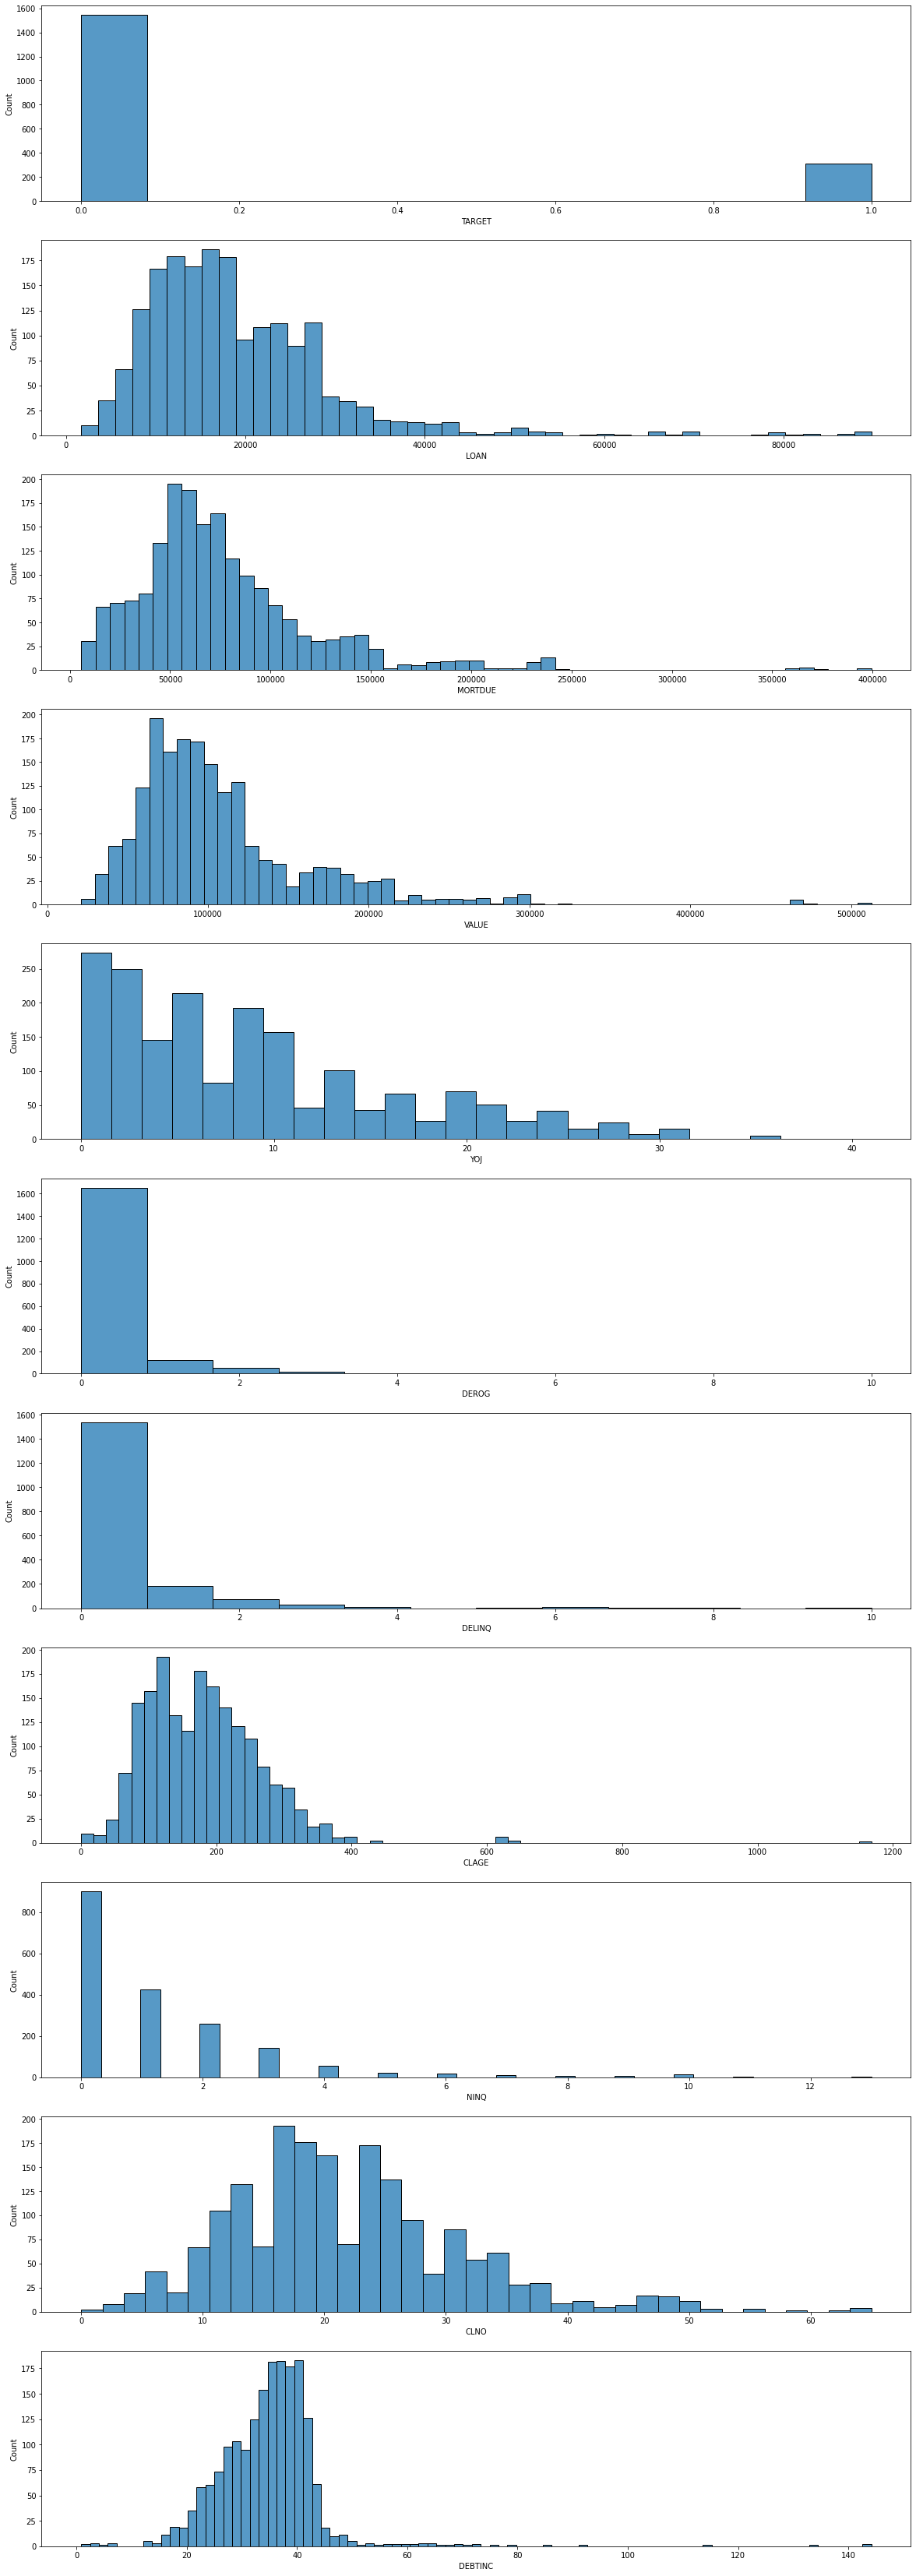

In [8]:
def histplot_graficos(data_frame, columns_list):
    n = 0
    fig, axes = plt.subplots(nrows=len(columns_list), figsize=(20, 60))
    sns.color_palette("Set2")
    for i in columns_list:
        sns.histplot(data_frame[i], ax=axes[n])
        n += 1


histplot_graficos(df, columns_list)


Observando las distribuciones de las variables, encontramos interesante **visualizar** los outliers de la columna `DEBTINC` a través de un boxplot

- Variable `DEBTINC`

Visualizamos los outliers de la columna `DEBTINC` a través de un **boxplot**.

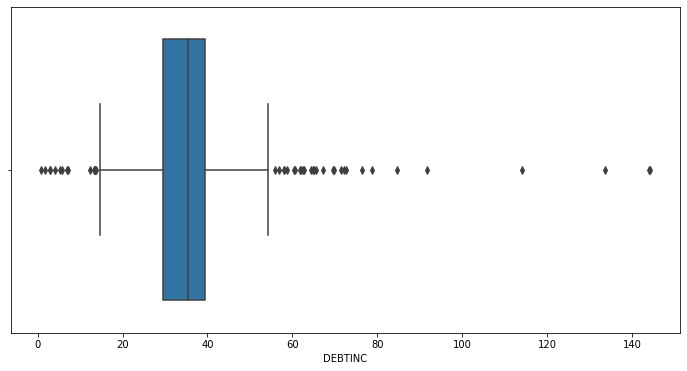

In [9]:
fig = plt.figure(figsize=(12, 6))
sns.color_palette("Set2")
sns.boxplot(x=df["DEBTINC"])


In [10]:
df["DEBTINC"]


0        29.209023
1        31.545694
2        41.210012
3        28.602076
4        30.686106
           ...    
1849     34.558417
1850     44.945929
1851     41.646731
1852    144.189001
1853     40.929793
Name: DEBTINC, Length: 1854, dtype: float64

Decidimos eliminar los outliers que están por encima del percentil 0.95 y aquéllos, por debajo del 0.05.

In [11]:
df_debtinc_qualite_95 = df["DEBTINC"].quantile(0.95)
df_debtinc_filtered = df[df["DEBTINC"] < df_debtinc_qualite_95]
df_debtinc_filtered


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1845,1,44400,67272.0,130818.0,9.0,0.0,0.0,112.591851,0.0,12.0,43.680965
1847,1,50200,197770.0,271676.0,16.0,0.0,0.0,146.862541,1.0,20.0,42.926580
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731


- Variable `LOAN`

Visualizamos los outliers de la columna `LOAN` a través de un **boxplot**.

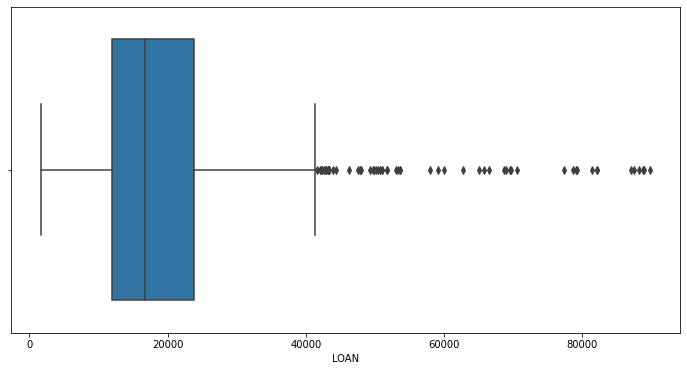

In [12]:
fig = plt.figure(figsize=(12, 6))
sns.color_palette("Set2")
sns.boxplot(x=df_debtinc_filtered["LOAN"])


Decidimos eliminar los outliers que están por encima del percentil 0.95.

In [13]:
quantile_95 = df_debtinc_filtered["LOAN"].quantile(0.95)
print(f"El outliers a eliminar es: {quantile_95}")


El outliers a eliminar es: 36100.0


In [14]:
df_filtered = df_debtinc_filtered[df_debtinc_filtered["LOAN"] < quantile_95]
df_filtered


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1825,1,31200,38352.0,80550.0,21.0,1.0,0.0,116.437908,0.0,14.0,35.381863
1826,1,32000,33148.0,69965.0,13.0,2.0,4.0,112.510865,3.0,27.0,36.021509
1827,1,33100,111917.0,156552.0,12.0,0.0,0.0,107.294900,2.0,37.0,41.441549
1828,1,33200,36705.0,78040.0,19.0,2.0,0.0,120.090143,0.0,13.0,35.015749


- Variable `MORTDUE`

Visualizamos los outliers de la columna `MORTDUE` a través de un **boxplot**.

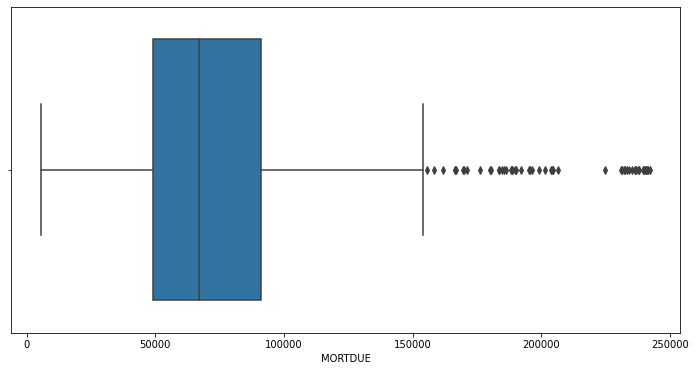

In [15]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x=df_filtered["MORTDUE"])


Decidimos eliminar los **outliers** que están por encima del percentil 0.95.

In [16]:
quantile_95 = df_filtered["MORTDUE"].quantile(0.95)
print(f"El outliers a eliminar es: {quantile_95}")


El outliers a eliminar es: 145711.25


In [17]:
df_filtered = df_filtered[df_filtered["MORTDUE"] < quantile_95]
df_filtered


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1820,1,28700,25190.0,59841.0,1.0,0.0,1.0,201.176783,0.0,11.0,35.729287
1825,1,31200,38352.0,80550.0,21.0,1.0,0.0,116.437908,0.0,14.0,35.381863
1826,1,32000,33148.0,69965.0,13.0,2.0,4.0,112.510865,3.0,27.0,36.021509
1827,1,33100,111917.0,156552.0,12.0,0.0,0.0,107.294900,2.0,37.0,41.441549


In [18]:
print(
    f"Se eliminó el siguiente porcentaje del total de registros: {round(100 - (1508 * 100 / 1854), 2)}%."
)


Se eliminó el siguiente porcentaje del total de registros: 18.66%.


## División en entrenamiento y evaluación

Preparamos los datos para el entrenamiento del modelo.

A continuación, dividimos los datos en conjuntos de entrenamiento y prueba.

Entrenamos el modelo con el 80% de las muestras y probamos con el 20% restante. Hacemos esto para evaluar el rendimiento del modelo en datos no vistos. 

Dividimos entre las instancias y etiquetas

In [19]:
X, y = df.iloc[:, 1:], df.TARGET


### Aplicamos un escalamiento estándar al conjunto de datos.

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


**Documentación:**

- [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

---
# Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

1. ¿De qué se trata el conjunto de datos?

El conjunto de datos es acerca del comportamiento crediticio histórico de los clientes de un banco, que hayan solicitado préstamos recientemente.

2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo a predecir, `TARGET`, es una variable binaria con los valores:
- `0` para los clientes que **NO** adeudan un préstamo.
- `1`para los clientes que **SI** adeudan un préstamo.

3. ¿Qué información (atributos) hay disponible para hacer la predicción?

- `LOAN`: Monto del préstamo requerido.
- `MORTDUE`: Deuda sobre el crédito hipotecario existente.
- `VALUE`: Valor actual de la propiedad.
- `YOJ`: Años en el trabajo actual.
- `DEROG`: Número de informes despectivos.
- `DELINQ`: Número de créditos en estado de deuda.
- `CLAGE`: Línea de crédito más antigua medida en meses.
- `NINQ`: Número de líneas de crédito recientes.
- `CLNO`: Número de líneas de créditos.
- `DEBTINC`: Cociente entre deuda e ingresos.

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

Estimamos que los atributos más importantes para la predicción pueden ser aquellos que determinan una relación entre el monto del préstamo solicitado `LOAN` y algunos factores de comportamiento del cliente con respecto a su morosidad `DELINQ` y el número de informes despectivos `DEROG`. 

También consideramos interesante para la predicción el uso de la variable `DEBTINC`, para relacionar la posibilidad de pagar la deuda teniendo en cuenta sus ingresos.


Aun así, concluimos usar todas las variables para el análisis, ya que no disponemos de un gran conjunto de datos y preferimos no perder la información.


# Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase `SGDClassifier` de `scikit-learn`.

**Documentación:**
- [SGD](https://scikit-learn.org/stable/modules/sgd.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)


## Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador `SGDClassifier` usando los valores por omisión (por defecto?) de `scikit-learn` para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión

### **SGDClassifier** con hiperparámetros por defecto, donde el tipo de modelo es **Linear SVM**

Fijamos la **semilla aleatoria** en un valor igual a 5.

In [22]:
rint = 5


Instanciamos la clase `SGDClassifier`.

In [23]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000, random_state=rint)


Entrenamos el modelo.

In [24]:
clf.fit(X_train, y_train)


SGDClassifier(max_iter=10000, random_state=5)

Generamos el conjunto de valores predichos a partir del conjunto de entrenamiento.

In [25]:
y_train_pred = clf.predict(X_train)


Mostramos los valores del conjunto `TARGET` de entrenamiento y los del conjunto de predicciones.

In [26]:
np.set_printoptions(threshold=np.inf)
print(f"⦁ y_train: cantidad de valores = {y_train.size}\n\n{np.array(y_train)}\n")
print("---" * 25)
print(
    f"\n⦁ y_train_pred: cantidad de valores = {y_train_pred.size}\n\n{y_train_pred}\n"
)


⦁ y_train: cantidad de valores = 1483

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 

Comparación de los valores reales frente a los valores predichos en un dataframe.

In [27]:
df = pd.DataFrame(data=y_train_pred, columns=["y_train_pred"])
df["y_train"] = np.array(y_train)
df = df[["y_train", "y_train_pred"]]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(
    f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas."
)


⦁ El dataframe de comparación cuenta con un total de 1483 filas y 2 columnas.


Muestra del dataframe de comparación.

In [28]:
rows_size = 24  # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")


,y_train,y_train_pred
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Métricas

In [29]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, zero_division=1)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
confusion_matrix_values = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

print(f"⦁ Accuracy = {accuracy}")
print(f"⦁ Precision = {precision}")
print(f"⦁ Recall = {recall}")
print(f"⦁ F1 = {f1}")
print(
    f"⦁ confusion_matrix_values =  TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}"
)


⦁ Accuracy = 0.8469318948078219
⦁ Precision = 0.5545454545454546
⦁ Recall = 0.4860557768924303
⦁ F1 = 0.5180467091295116
⦁ confusion_matrix_values =  TN: 1134, FP: 98, FN: 129, TP: 122
[[1134   98]
 [ 129  122]]


In [30]:
data = {
    "type_of_set": "train",
    "hiperparameters": "default",
    "loss": "hinge",
    "penalty": "l2",
    "alpha": "",
    "learning_rate": "",
    "eta0": "",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}
results_df = pd.DataFrame(data, index=[0])
results_df


,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047


Generamos el conjunto de valores predichos a partir del conjunto de test.

In [31]:
y_test_pred = clf.predict(X_test)


Mostramos los valores del conjunto `TARGET` de test y los del conjunto de predicciones.

In [32]:
np.set_printoptions(threshold=np.inf)
print(f"⦁ y_test: cantidad de valores = {y_test.size}\n\n{np.array(y_test)}\n")
print("---" * 25)
print(f"\n⦁ y_test_pred: cantidad de valores = {y_test_pred.size}\n\n{y_test_pred}\n")


⦁ y_test: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_test_pred: cantidad de valores = 371

[0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1

Comparación de los valores reales frente a los valores predichos en un dataframe.

In [33]:
df = pd.DataFrame(data=y_test_pred, columns=["y_test_pred"])
df["y_test"] = np.array(y_test)
df = df[["y_test", "y_test_pred"]]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(
    f"⦁ El DataFrame de comparación cuenta con un total de {rows} filas y {cols} columnas."
)


⦁ El DataFrame de comparación cuenta con un total de 371 filas y 2 columnas.


Muestra del DataFrame de comparación.

In [34]:
rows_size = 24  # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")


,y_test,y_test_pred
0,0,0
1,0,1
2,0,0
3,1,1
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,0,0


**Métricas**

In [35]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=1)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_matrix_values = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(
    f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}"
)


⦁ accuracy = 0.8490566037735849
⦁ precision = 0.52
⦁ recall = 0.4482758620689655
⦁ f1 = 0.48148148148148145
⦁ confusion_matrix_values = TN: 289, FP: 24, FN: 32, TP: 26
[[289  24]
 [ 32  26]]


In [36]:
data = {
    "type_of_set": "test",
    "hiperparameters": "default",
    "loss": "hinge",
    "penalty": "l2",
    "alpha": "",
    "learning_rate": "",
    "eta0": "",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df


,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481


## Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de:  
- loss  
- tasas de entrenamiento (learning_rate)  
- tasas de regularización

Para ello, usar **grid-search** y **5-fold cross-validation** sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar **accuracy**, **promedio** y **varianza** para todas las configuraciones.

Para la **mejor configuración** encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión

**Documentación:**
- [Grid Search](https://scikit-learn.org/stable/modules/grid_search.html)
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Generamos un diccionario con distintos valores para los hiperparámetros:
- `loss`: función de costo asociada a un tipo de modelo en particular.
- `alpha`: coeficiente del término de regularización.
- `learning_rate`: tipo de tasa de aprendizaje.
- `eta0`: valor inicial de la tasa de aprendizaje.

In [37]:
param_dist = {
    "loss": ["hinge", "log", "perceptron"],  # SVM  # logistic regression  # perceptron
    "alpha": loguniform(1e-4, 1e2),  # de 0.0001 a 100.0
    "learning_rate": [
        "constant",
        "optimal",
        # "invscaling"
    ],
    "eta0": uniform(
        low=0, high=100, size=30
    ),  # The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. Values must be in the range (0.0, inf).
}


Por medio de la clase `RandomizedSearchCV`, empleamos una grilla de parámetros para generar distintas combinaciones de valores de hiperparámetros aleatoriamente, y aplicamos validación cruzada.

- La cantidad inicial de combinaciones a formar de los valores de los **hiperparámetros** es 30.
- La **semilla aleatoria** es la misma que antes: 5.

In [38]:
combinations_size = 30  # Setear la cantidad total de combinaciones a crear de los valores de los hiperparámetros.
model = SGDClassifier(random_state=rint)
cv = RandomizedSearchCV(
    model, param_dist, n_iter=combinations_size, cv=5, random_state=rint
)


Entrenamos el modelo.

In [39]:
cv.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=SGDClassifier(random_state=5), n_iter=30,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5f988e0750>,
                                        'eta0': array([ 2.61823972, 77.23473625, 64.42886168, 77.4532301 , 55.9307173 ,
       93.12191328, 71.66125917, 21.74951144,  5.91681768, 78.63332824,
        9.9240295 , 75.67267371,  7.96693786, 26.36718078, 49.13471571,
       71.10308256, 56.39481139,  8.27882569, 97.75315671, 18.46988909,
       27.51064952, 60.89620295, 19.71277804, 79.52545005, 41.76007304,
       76.15523915, 46.44205097, 43.07565129, 72.52424579, 69.27966954]),
                                        'learning_rate': ['constant',
                                                          'optimal'],
                                        'loss': ['hinge', 'log', 'perceptron']},
                   random_state=5)

Cargamos los resultados del entrenamiento en un dataframe, y realizamos una vista previa del mismo, donde se incluyen los valores de la media y la varianza de cada configuración.

In [40]:
results = cv.cv_results_
df = pd.DataFrame(results)
interesting_columns = [
    "param_loss",
    "param_alpha",
    "param_learning_rate",
    "param_eta0",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]
df[interesting_columns].sort_values(by="rank_test_score").reset_index(drop=True)


,param_loss,param_alpha,param_learning_rate,param_eta0,mean_test_score,std_test_score,rank_test_score
0,log,0.001482,optimal,75.672674,0.869858,0.008694,1
1,hinge,0.000203,optimal,71.661259,0.859080,0.017454,2
2,hinge,0.000305,optimal,56.394811,0.857053,0.015277,3
3,log,0.083143,optimal,7.966938,0.855025,0.003608,4
4,hinge,0.2394,optimal,75.672674,0.846262,0.003859,5
5,hinge,0.397718,optimal,97.753157,0.839515,0.003433,6
6,perceptron,0.000244,optimal,56.394811,0.832815,0.040011,7
7,log,34.395188,constant,49.134716,0.830749,0.001259,8
8,log,18.510512,optimal,9.924029,0.830749,0.001259,8
9,log,2.105511,optimal,77.234736,0.830749,0.001259,8


Capturamos el mejor estimador, es decir aquella combinación de valores de **hiperparámetros** que mejoran las métricas de las predicciones.

In [41]:
best_estimator = cv.best_estimator_
best_estimator


SGDClassifier(alpha=0.001481787510127265, eta0=75.67267370835935, loss='log',
              random_state=5)

In [42]:
new_params = cv.best_params_
loss = new_params["loss"]
alpha = new_params["alpha"]
learning_rate = new_params["learning_rate"]
eta0 = new_params["eta0"]

print("Los nuevos valores de los hiperparámetros son:")
print(f"⦁ loss = {loss}")
print(f"⦁ alpha = {alpha}")
print(f"⦁ learning_rate = {learning_rate}")
print(f"⦁ eta0 = {eta0}")


Los nuevos valores de los hiperparámetros son:
⦁ loss = log
⦁ alpha = 0.001481787510127265
⦁ learning_rate = optimal
⦁ eta0 = 75.67267370835935


### **SGDClassifier** con hiperparámetros modificados

Fijamos la **semilla aleatoria** en un valor igual a 5.

In [43]:
rint = 5


Instanciamos la clase `SGDClassifier` con los mejores valores encontrados de los **hiperparámetros**.

In [44]:
clf = SGDClassifier(
    loss=loss,
    alpha=alpha,
    learning_rate=learning_rate,
    eta0=eta0,
    penalty="l2",
    max_iter=1000,
    random_state=rint,
)


Entrenamos el modelo.

In [45]:
clf.fit(X_train, y_train)


SGDClassifier(alpha=0.001481787510127265, eta0=75.67267370835935, loss='log',
              random_state=5)

Generamos el conjunto de valores predichos a partir del conjunto de entrenamiento.

In [46]:
y_train_pred = clf.predict(X_train)


Mostramos los valores del conjunto `TARGET` de entrenamiento y los del conjunto de predicciones.

In [47]:
np.set_printoptions(threshold=np.inf)
print(f"⦁ y_train: cantidad de valores = {y_train.size}\n\n{np.array(y_train)}\n")
print("---" * 25)
print(
    f"\n⦁ y_train_pred: cantidad de valores = {y_train_pred.size}\n\n{y_train_pred}\n"
)


⦁ y_train: cantidad de valores = 1483

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 

Comparación de los valores reales frente a los valores predichos en un dataframe.

In [48]:
df = pd.DataFrame(data=y_train_pred, columns=["y_train_pred"])
df["y_train"] = np.array(y_train)
df = df[["y_train", "y_train_pred"]]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(
    f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas."
)


⦁ El dataframe de comparación cuenta con un total de 1483 filas y 2 columnas.


Muestra del dataframe de comparación.

In [49]:
rows_size = 24  # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")


,y_train,y_train_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Métricas

In [50]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, zero_division=1)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
confusion_matrix_values = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(
    f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}"
)


⦁ accuracy = 0.8718813216453135
⦁ precision = 0.7850467289719626
⦁ recall = 0.3346613545816733
⦁ f1 = 0.4692737430167598
⦁ confusion_matrix_values = TN: 1209, FP: 23, FN: 167, TP: 84
[[1209   23]
 [ 167   84]]


In [51]:
data = {
    "type_of_set": "train",
    "hiperparameters": "modified",
    "loss": loss,
    "penalty": "l2",
    "alpha": alpha,
    "learning_rate": learning_rate,
    "eta0": eta0,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df


,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
2,train,modified,log,l2,0.001482,optimal,75.672674,0.871881,0.785047,0.334661,0.469274


Generamos el conjunto de valores predichos a partir del conjunto de test.

In [52]:
y_test_pred = clf.predict(X_test)


Mostramos los valores del conjunto `TARGET` de test y los del conjunto de predicciones.

In [53]:
np.set_printoptions(threshold=np.inf)
print(f"⦁ y_test: cantidad de valores = {y_test.size}\n\n{np.array(y_test)}\n")
print("---" * 25)
print(f"\n⦁ y_test_pred: cantidad de valores = {y_test_pred.size}\n\n{y_test_pred}\n")


⦁ y_test: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_test_pred: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0

Comparación de los valores reales frente a los valores predichos en un **DataFrame**.

In [54]:
df = pd.DataFrame(data=y_test_pred, columns=["y_test_pred"])
df["y_test"] = np.array(y_test)
df = df[["y_test", "y_test_pred"]]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(
    f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas."
)


⦁ El dataframe de comparación cuenta con un total de 371 filas y 2 columnas.


Muestra del dataframe de comparación.

In [55]:
rows_size = 24  # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")


,y_test,y_test_pred
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


**Métricas**

In [56]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=1)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_matrix_values = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(
    f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}"
)


⦁ accuracy = 0.8706199460916442
⦁ precision = 0.7272727272727273
⦁ recall = 0.27586206896551724
⦁ f1 = 0.4
⦁ confusion_matrix_values = TN: 307, FP: 6, FN: 42, TP: 16
[[307   6]
 [ 42  16]]


In [57]:
data = {
    "type_of_set": "test",
    "hiperparameters": "modified",
    "loss": loss,
    "penalty": "l2",
    "alpha": alpha,
    "learning_rate": learning_rate,
    "eta0": eta0,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df


,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
2,train,modified,log,l2,0.001482,optimal,75.672674,0.871881,0.785047,0.334661,0.469274
3,test,modified,log,l2,0.001482,optimal,75.672674,0.870620,0.727273,0.275862,0.400000


In [58]:
results_df = results_df.sort_values(by="type_of_set", ascending=False)
results_df = results_df.reset_index(drop=True)
results_df


,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,train,modified,log,l2,0.001482,optimal,75.672674,0.871881,0.785047,0.334661,0.469274
2,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
3,test,modified,log,l2,0.001482,optimal,75.672674,0.870620,0.727273,0.275862,0.400000


>**Observación:**
>
>Observamos que al modificar los hiperparámetros el `accuracy` del modelo respecto del conjunto de **entrenamiento** aumentó en un 2.49%, y el `accuracy` respecto del conjunto de **test** creció en un 2.16%.
>
>En ambos conjuntos, la **función de costo** elegida para mejorar las métricas fue la **regresión logística**.


## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán **árboles de decisión** para predecir la variable objetivo.

Para ello, deberán utilizar la clase `DecisionTreeClassifier` de `scikit-learn`.

Documentación:
- [Tree](https://scikit-learn.org/stable/modules/tree.html)
- [Tips on practical use](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Tree Etructure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión


### **DecisionTreeClassifier** con hiperparámetros por defecto

Definimos el modelo utilizando la clase `DecisionTreeClassifier`, utilizando los valores de parámetros por defecto. 

Luego realizamos el entrenamiento del modelo.

In [59]:
clf_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

Realizamos la predicción tanto para el conjunto de datos de entrenamiento, como para el de validación.


In [60]:
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)


In [61]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_acc:0.2}")
print(f"Test accuracy: {test_acc:0.2}")


Train accuracy: 1.0
Test accuracy: 0.89


In [62]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       313
           1       0.63      0.67      0.65        58

    accuracy                           0.89       371
   macro avg       0.78      0.80      0.79       371
weighted avg       0.89      0.89      0.89       371



Inspeccionamos **el árbol de decisión**


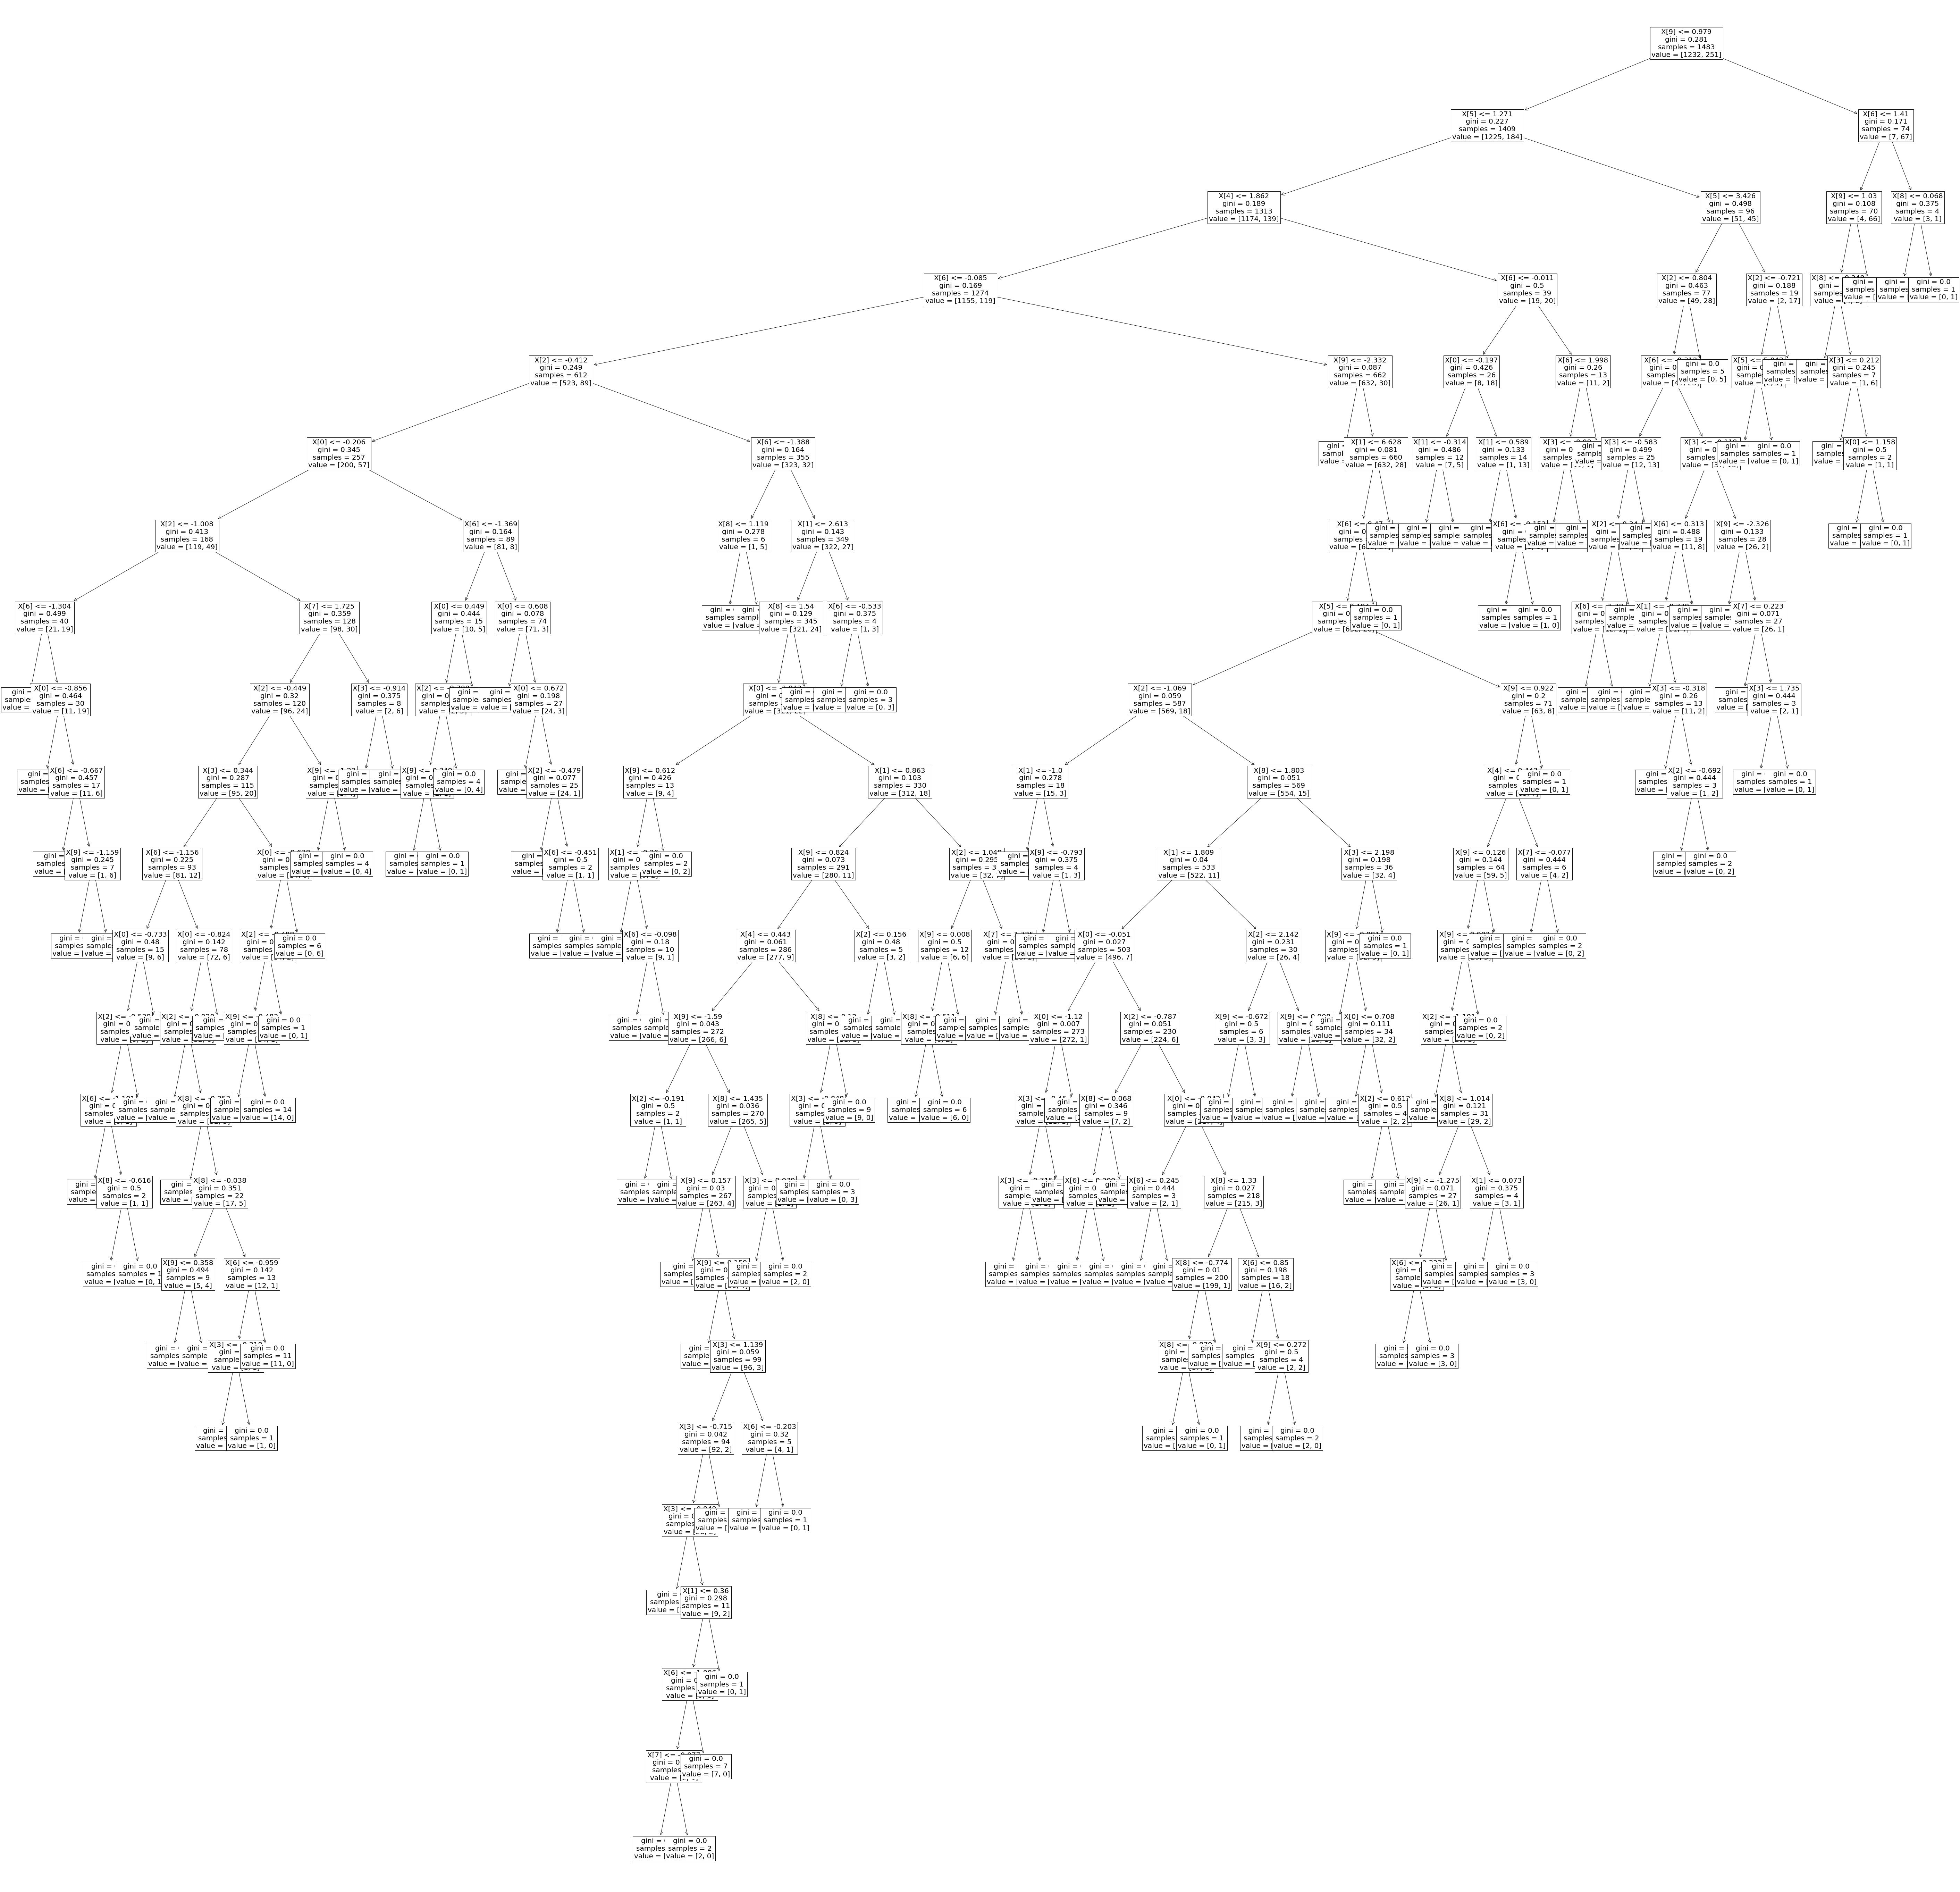

In [65]:
plt.figure(figsize=(100, 100))
plot_tree(clf_tree,  fontsize=20);
plt.show()

Creamos una función para calcular la **probabilidad**

In [66]:
# Función que calcula la probabilidad
def probs(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return probs


Creamos una función para calcular la **entropía**

In [67]:
# Función que calcula la entropía
def entropy(y):
    p = probs(y)
    return -np.sum(p * np.log2(p))


Calculamos la **entropía** de nuestro conjunto de entrenamiento

In [68]:
print(f"Entropía: {entropy(y_train):0.2}")


Entropía: 0.66


Observamos el reporte de **clasificación** sobre el conjunto de de **entrenamiento** y sobre el de **validación**.


In [69]:
print(
    "Reporte sobre el conjunto de entrenamiento\n",
    classification_report(y_train, y_train_pred),
)
print(
    "Reporte sobre el conjunto de validación\n",
    classification_report(y_test, y_test_pred),
)


Reporte sobre el conjunto de entrenamiento
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483

Reporte sobre el conjunto de validación
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       313
           1       0.63      0.67      0.65        58

    accuracy                           0.89       371
   macro avg       0.78      0.80      0.79       371
weighted avg       0.89      0.89      0.89       371



Analizamos la matriz de confusión


In [70]:
confusion_matrix(y_test, y_test_pred)


array([[290,  23],
       [ 19,  39]])

In [71]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")


True Negative: 290
False Positive: 23
False Negative: 19
True Positive: 39


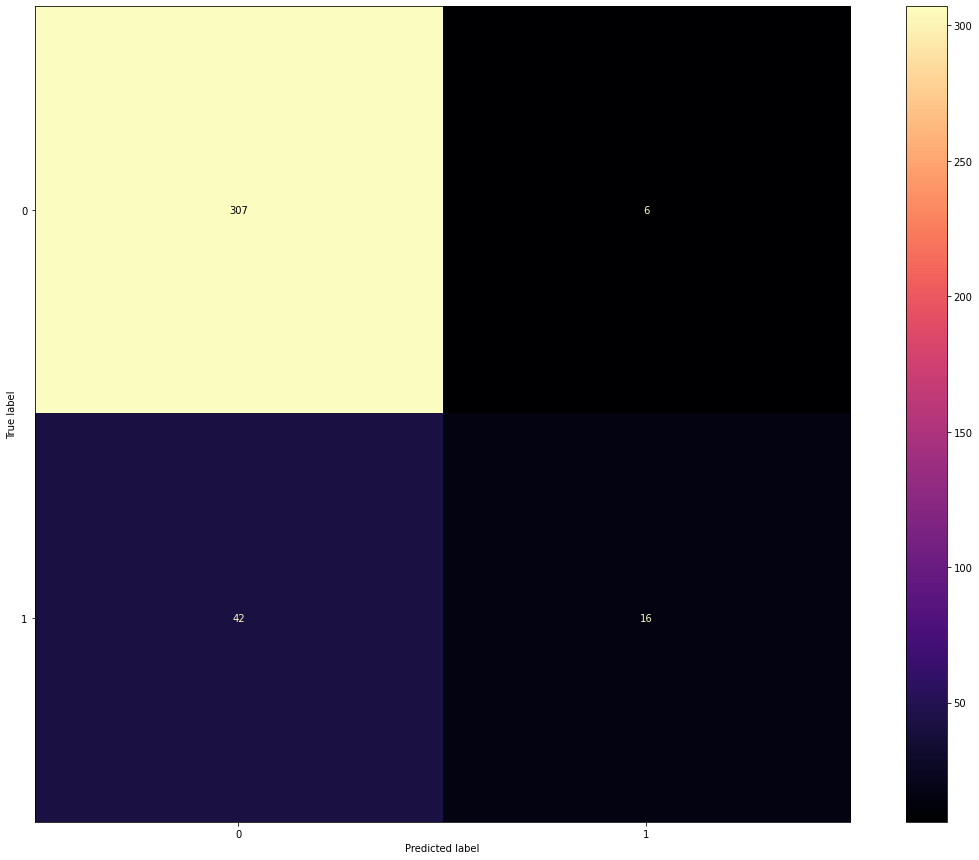

In [72]:
plot_confusion_matrix(clf, X_test, y_test, cmap="magma");


>**Observación**:
>
> - El árbol tiene una profundidad muy alta, perdiendo interpretabilidad.


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del `DecisionTreeClassifier`. Como mínimo:  
- `__criterion__`: probar diferentes criterios de partición  
- `__max_depth__`: profundidad máxima del árbol    
- `__min_samples_leaf__`: cantidad mínima de samples por hoja

Para ello, usar `grid-search` y `5-fold cross-validation` sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- [Grid Search](https://scikit-learn.org/stable/modules/grid_search.html)
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### **DecisionTreeClassifier** con Ajuste de Hiperparámetros


A continuación vamos a definir el diccionario con los **hiperparámetros** y los **valores** de estos parámetros, con los cuales vamos a realizar todas las combinaciones posibles durante la validación cruzada.

In [73]:
DecisionTreeClassifier??

In [74]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [2, 4, 6],
    "random_state": [0, 2, 4],
}


Analizaremos todas las combinaciones posibles de los parametros declarados en el diccionario `param_grid`.

In [75]:
for params in ParameterGrid(param_grid):
    print(params)
    model = DecisionTreeClassifier(**params)


{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 4, 'm

A continuación, utilizaremos la función `GridSearchCV`, para realizar la validación cruzada sobre la lista de parámetros declarada anteriormente. 

Utilizando el **método de división estratificada en 5** (default value) subconjuntos partiendo del conjunto de entrenamiento. 

La división estratificada mantiene en la subdivisiones la misma proporción de clases que existen en nuestro dataset original. 

De esta manera, obtendremos una grilla con los resultados basados en la **accuracy** para todas las combinaciones posibles de nuestros parámetros.


In [76]:
model = DecisionTreeClassifier()

cv = GridSearchCV(model, param_grid, scoring="accuracy", cv=5)
cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 4, 6],
                         'random_state': [0, 2, 4]},
             scoring='accuracy')

In [77]:
results = cv.cv_results_
params = results["params"]
mean = results["mean_test_score"]
std = results["std_test_score"]
rank = results["rank_test_score"]

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")


crit.	depth	| mean	std	rank
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	4	| 0.88	0.02	23
gini	4	| 0.88	0.02	26
gini	4	| 0.88	0.02	17
gini	4	| 0.88	0.01	6
gini	4	| 0.88	0.02	16
gini	4	| 0.88	0.01	10
gini	4	| 0.88	0.01	6
gini	4	| 0.88	0.01	10
gini	4	| 0.88	0.01	10
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	13
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	27
gini	6	| 0.88	0.01	18
gini	6	| 0.88	0.02	13
gini	6	| 0.88	0.02	8
gini	6	| 0.88	0.02	8
gini	8	| 0.88	0.02	25
gini	8	| 0.87	0.02	35
gini	8	| 0.88	0.02	30
gini	8	| 0.87	0.03	37
gini	8	| 0.87	0.02	39
gini	8	| 0.87	0.02	41
gini	8	| 0.88	0.03	21
gini	8	| 0.88	0.03	21
gini	8	| 0.88	0.03	15
gini	10	| 0.88	0.02	2
gini	10	| 0.88	0.02	24
gini	10	| 0.89	0.01	1
gini	10	| 0.88	0.02	3
gini	10	| 0.88	0.03	29
gini	10	| 0.88	0.02	4
gini	10	| 0.88	0.03	19
gini	10	| 0.88	0.03	19
gini

In [78]:
df = pd.DataFrame(results)
df = df[
    [
        "param_criterion",
        "param_max_depth",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
df = df.sort_values(by="rank_test_score")
df


,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
38,gini,10,0.885374,0.013945,1
36,gini,10,0.882676,0.019574,2
39,gini,10,0.881343,0.022609,3
41,gini,10,0.881338,0.019380,4
44,gini,10,0.879318,0.032216,5
...,...,...,...,...,...
85,entropy,10,0.860431,0.015915,86
86,entropy,10,0.859084,0.015874,87
89,entropy,10,0.855044,0.027269,88
88,entropy,10,0.853021,0.028055,89


A través de la función, vamos a explorar el mejor modelo y parámetros obtenidos a través de la validación cruzada.


In [79]:
cv.best_params_


{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'random_state': 4}

Exploramos el mejor modelo encontrado


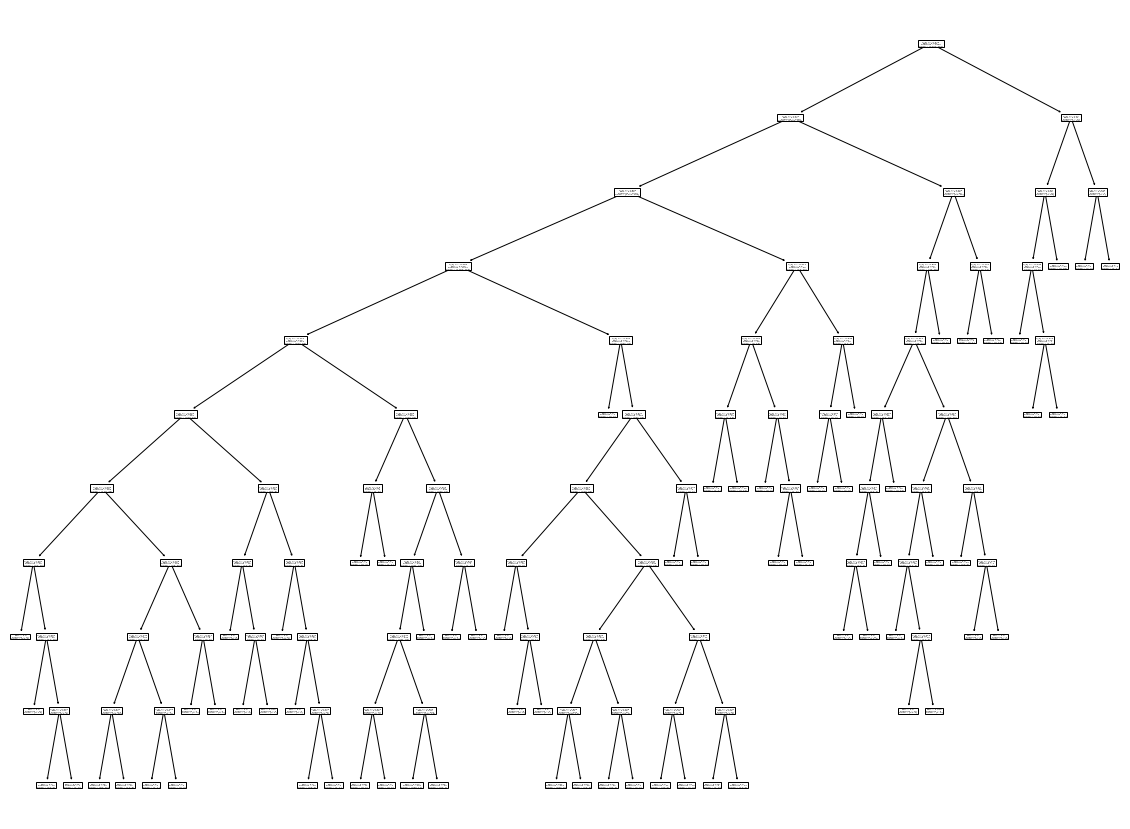

In [80]:
best_model = cv.best_estimator_
plot_tree(best_model);


Ahora vamos a **predecir** con el **mejor** modelo encontrado sobre el **conjunto de entrenamiento** y **evaluación**

In [81]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


In [82]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_acc:0.2}")
print(f"Test accuracy: {test_acc:0.2}")


Train accuracy: 0.95
Test accuracy: 0.91


Analizamos las métricas para el conjunto de datos de entrenamiento

In [83]:
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1232
           1       0.98      0.72      0.83       251

    accuracy                           0.95      1483
   macro avg       0.96      0.86      0.90      1483
weighted avg       0.95      0.95      0.95      1483



Analizamos las métricas para el conjunto de datos de evaluación


In [84]:
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.92      0.97      0.95       313
           1       0.80      0.55      0.65        58

    accuracy                           0.91       371
   macro avg       0.86      0.76      0.80       371
weighted avg       0.90      0.91      0.90       371



Matriz de confusión para el conjunto de datos de entrenamiento


In [85]:
confusion_matrix(y_train, y_train_pred)


array([[1229,    3],
       [  70,  181]])

Matriz de confusión para el conjunto de datos de evaluación

In [86]:
confusion_matrix(y_test, y_test_pred)


array([[305,   8],
       [ 26,  32]])

In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")


True Negative: 305
False Positive: 8
False Negative: 26
True Positive: 32


Graficamos la matriz de confusión

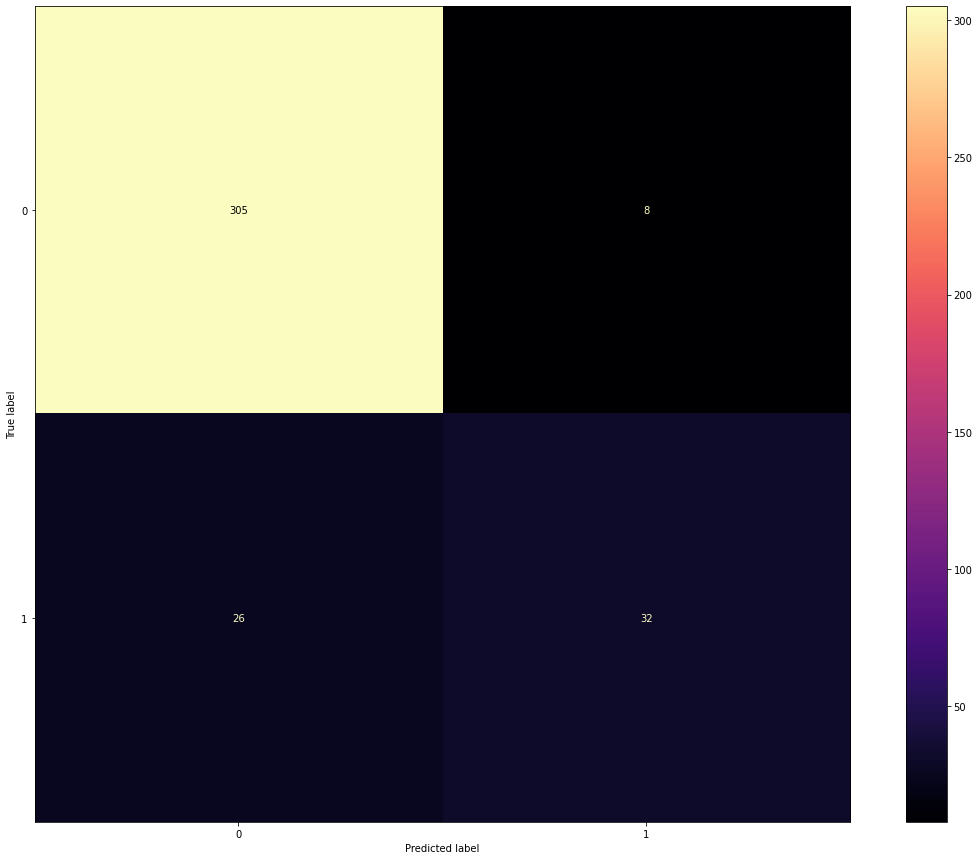

In [88]:
plot_confusion_matrix(best_model, X_test, y_test, cmap="magma");
 


A comparación del árbol anterior, notamos que las medidas elegidas de nuestro predictor  mejoran bastante la interpretabilidad del árbol.
